# Multiclass classification using _ImaGene_

This tutorial will show you how to perform a multiclass classification using _ImaGene_.
In this example, our goal is to classify whether a given _locus_ is under positive selection or neutrally evolving with 3 classes of selection coefficient (0,200,400 in $2N_e$ units with $N_e=10000$) and we will be using the case of lactase persistence in European populations.

Please refer to the tutorial for binary classification for an in-depth explanation of the case study and main steps of the pipeline.
Here we will mostly focus on the main differences.

In this tutorial you will be utilising a GPU which will help speed up the training process. To enable the GPU, you need to go to...<br>
> Runtime >> Change runtime type >> select GPU as a hardware accelerator.



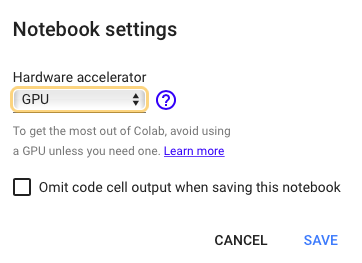

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') #Follow the link, copy and paste the verification code, and press Enter 

In [ ]:
!ln -s "/content/drive/My Drive" /gdrive #Create a symbolic link to the drive. The path to the drive is now "/gdrive".

**Check if GPU is working** 

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name() #If GPU is enabled, the output will be '/device:GPU:0'

In [ ]:
!python --version #Check if Python is version 3.6 which is compatible to Tensorflow2

**Install bc package (for creating simulations)**

In [ ]:
!sudo apt install bc

**Download msms files**

In [ ]:
!wget https://www.mabs.at/ewing/msms/msms3.2rc-b163.zip

In [ ]:
!sudo apt-get install unzip #Install an unzip utility tool

In [ ]:
!unzip msms3.2rc-b163.zip #Unzip msms files

Since you have already cloned the ImaGene folder to the Drive from tutorial `Colab_01_binary`, this time you can retrieve data from the Drive directly.

**Copy .vcf file and create a Multiclass directory**

In [ ]:
!cp -R /gdrive/ImaGene/Tutorials/LCT.CEU.vcf /content #Copy the .vcf to the working directory 

In [ ]:
!mkdir /gdrive/ImaGene/Tutorials/Multiclass #Create "Multiclass" directory

In [ ]:
%tensorflow_version 2.x
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import pymc3

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import plot_model
from keras.models import load_model

import itertools
import skimage.transform
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pydot # optional, but required by keras to plot the model

In [ ]:
%run -i /gdrive/ImaGene/ImaGene.py

### 1. read data from VCF file and store it into _ImaGene_ objects

In [ ]:
file_LCT = ImaFile(nr_samples=198, VCF_file_name='LCT.CEU.vcf')
gene_LCT = file_LCT.read_VCF()

Here we assume we are unsure about the ancestral/derived polarisation and we switch labelling of alleles to major/minor.
We also then retain all polymorphic sites and discard columns corresponding to sites with a sample minor allele frequency of 0 (a suitable threshold is 0.005 which is < 1/198).

In [ ]:
gene_LCT.majorminor()
gene_LCT.filter_freq(0.005)

Check the dimensions and plot it.

In [ ]:
gene_LCT.summary()
gene_LCT.plot()

As an illustration, we order rows based on their genetic distance from the most frequent haplotype. 

In [ ]:
gene_LCT.sort('rows_dist')
gene_LCT.plot()

### 2. run and process simulations to be used for training the neural network

We provide an example of parameter file called `params_multiclass` which simulates a total of 250,000 loci of 80kbp either under neutral evolution or positive selection with additive effect and allelic selection coefficients of 100, 200, 300, or 400 in $2N_e$ units with $N_e=10,000$.
All other parameters are set as in the example of binary classification.

In [ ]:
path = '/gdrive/ImaGene/Tutorials/' #Change to your path

Open, edit, save and class `params_multiclass.txt` file to specify directories and simulation parameters. Here I assume that simulations will be stored in `path+Multiclass/`.

Edit `params_multiclass.txt`
*   DIRMSMS="/content/msms/lib/msms.jar"
*   DIRDATA="/gdrive/ImaGene/Tutorials/Multiclass "

In [ ]:
import subprocess
subprocess.call("bash /gdrive/ImaGene/generate_dataset.sh /gdrive/ImaGene/Tutorials/params_multiclass.txt".split())

As an illustration, read the first batch of simulations to explore their content. Retain only 200 data points per class for a quick example.

In [ ]:
file_sim = ImaFile(simulations_folder=path+'Multiclass/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=200)
gene_sim.summary()

As expected we have 1000 images (200 for each one of the 5 classes).
The average number of columns is $\approx 285$.

We can check the sample allele frequency for the selected allele. Recall that we imposed selection to be acting in the middle of the region. Therefore, the targeted allele will be in position '0.5' in the _msms_ file.

In [ ]:
freqs = calculate_allele_frequency(gene_sim, 0.5)
plt.scatter(gene_sim.targets, freqs, marker='o')
plt.xlabel('Selection coefficient')
plt.ylabel('Allele frequency')

Perform the same data processing as done for LCT. As an exmaple, we resize all images to the average dimensions of (198,285).

In [ ]:
gene_sim.majorminor()
gene_sim.filter_freq(0.005)
gene_sim.sort('rows_dist')
gene_sim.resize((198,285))
gene_sim.convert()

Suppose that we are just interested in a classification of 3 classes: 0, 200, 400.
For doing that, first we need to set `.classes` to the desired values and then we need to take a subset of the data corresponding to the desired classes only.
We can achieve these steps with the following lines.

In [ ]:
gene_sim.classes = np.array([0,200,400])
gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes))
gene_sim.summary()

We now have 600 data points corresponding to the desired classes, as expected. 

### 3. implement, train and evaluate the neural network

As discussed in the tutorial on binary classification, we need to repeat this procedure across all batches of data leaving the last one for testing. We retain 1000 images per class as an illustration.

In [ ]:
i = 1
while i <= 10:

    # simluations 
    file_sim = ImaFile(simulations_folder=path+'Multiclass/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=1000)
    
    # manipulate data:
    # switch to major/minor allele polarisation
    # filter our monomorphic sites
    # sort rows by genetic distance
    gene_sim.majorminor()
    gene_sim.filter_freq(0.005)
    gene_sim.sort('rows_dist')
    gene_sim.resize((198, 285))
    gene_sim.convert()
    
    # use only classes 0,200,400
    gene_sim.classes = np.array([0,200,400])
    gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes))

    # randomise data
    gene_sim.subset(get_index_random(gene_sim))

    # convert targets to categorical data
    gene_sim.targets = to_categorical(gene_sim.targets)
    
    # at first iteration we build the model 
    if i == 1:

        model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=len(gene_sim.classes), activation='softmax')])
        model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        net_LCT = ImaNet(name='[C32+P]+[C64+P]x2+D128')

    # training for iterations from 1 to 9
    if i < 10:
        score = model.fit(gene_sim.data, gene_sim.targets, batch_size=32, epochs=1, verbose=1, validation_split=0.10)
        net_LCT.update_scores(score)
    else:
        # testing for iteration 10
        net_LCT.test = model.evaluate(gene_sim.data, gene_sim.targets, batch_size=None, verbose=1)
        net_LCT.predict(gene_sim, model)

    i += 1

In [ ]:
# save final (trained) model
model.save(path+'Data/model.multi.h5')

# save testing data
gene_sim.save(path+'Data/gene_sim.multi')

# save network
net_LCT.save(path+'Data/net_LCT.multi')

In [ ]:
# load the objects above
model = load_model(path+'Data/model.multi.h5')
gene_sim = load_imagene(file=path+'Data/gene_sim.multi')
net_LCT = load_imanet(path+'Data/net_LCT.multi')

In [ ]:
# assess the training
net_LCT.plot_train()

In [ ]:
# print the testing results [loss, accuracy]
print(net_LCT.test)

In [ ]:
# plot a confusion matrix (on the last gene_sim object which represents the testing data)
net_LCT.plot_cm(gene_sim.classes)

### 4. deploy the trained network on your genomic data of interest

Finally we use the trained network to predict the class of natural selection on our locus of interest.
First we need to resize our real data to match the data used for training.
After that, we need to convert the data into the required format.

In [ ]:
gene_LCT.resize((198,285))
gene_LCT.convert()
gene_LCT.summary()

The output of this command will give us the class scores (0, 200, 400).

In [ ]:
model.predict(gene_LCT.data, batch_size=None)